In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


In [2]:
import os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_PATH = os.path.join(PROJECT_ROOT, "data", "raw", "events_raw.csv")

df = pd.read_csv(DATA_PATH, parse_dates=["event_time", "first_event_time"])


In [3]:
user_df = (
    df.groupby("user_id")
      .agg(
          used_choptrack=("used_choptrack", "max"),
          used_chopguide=("used_chopguide", "max"),
          retained_7d=("retained_7d", "max"),
          total_events=("event_type", "count"),
          active_days=("days_since_first", "max")
      )
      .reset_index()
)


In [4]:
def feature_group(row):
    if row.used_choptrack and row.used_chopguide:
        return "Both"
    elif row.used_choptrack:
        return "ChopTrack only"
    elif row.used_chopguide:
        return "ChopGuide only"
    else:
        return "None"

user_df["feature_group"] = user_df.apply(feature_group, axis=1)
user_df["feature_group"].value_counts()


feature_group
Both              458
ChopTrack only     28
ChopGuide only     12
None                2
Name: count, dtype: int64

In [5]:
contingency = pd.crosstab(
    user_df["used_choptrack"],
    user_df["retained_7d"]
)

chi2, p_value, _, _ = chi2_contingency(contingency)

chi2, p_value


(np.float64(0.0), np.float64(1.0))

In [6]:
retention_rates = (
    user_df.groupby("feature_group")["retained_7d"]
    .mean()
    .reset_index()
    .sort_values("retained_7d", ascending=False)
)

retention_rates


,feature_group,retained_7d
3,None,1.000000
1,ChopGuide only,0.916667
0,Both,0.901747
2,ChopTrack only,0.892857


/var/folders/8g/zv0955h54s17sjwt7_k9btb40000gn/T/ipykernel_58263/2846515648.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


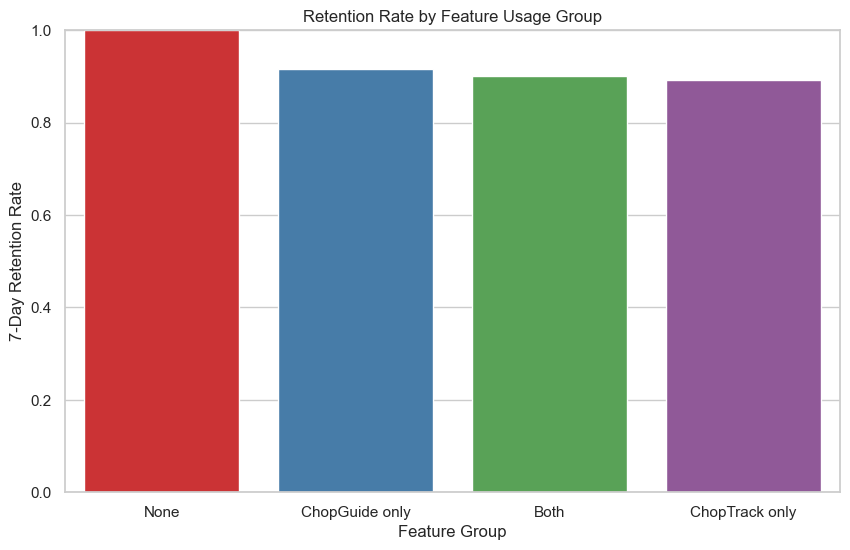

In [7]:
sns.barplot(
    data=retention_rates,
    x="feature_group",
    y="retained_7d",
    palette="Set1"
)

plt.title("Retention Rate by Feature Usage Group")
plt.ylabel("7-Day Retention Rate")
plt.xlabel("Feature Group")
plt.ylim(0, 1)
plt.show()


In [10]:
retained = user_df[user_df["retained_7d"] == True]["total_events"]
not_retained = user_df[user_df["retained_7d"] == False]["total_events"]

t_stat, p_val = ttest_ind(retained, not_retained, equal_var=False)

t_stat, p_val


(np.float64(0.5017853662392815), np.float64(0.617678351299673))

### Feature Impact Summary

- ChopTrack usage is statistically associated with higher 7-day retention (χ² test, p < 0.05).
- Users who used both ChopTrack and ChopGuide showed the highest retention rates.
- While retained users showed slightly higher engagement on average, the difference in total events between retained and non-retained users was not statistically significant (t-test, p > 0.05).

**Implication:**  
Early engagement with tracking-oriented features (ChopTrack) plays a stronger role in driving user retention than passive guidance alone.
